# Proximity Detection in Vehicles using YOLOv3 and OpenCV

## GPU and CPU Information

In [ ]:
#GPU information
!nvidia-smi -L
!nvidia-smi
!lscpu |grep 'Model name'
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'
#hard disk space that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla T4 (UUID: GPU-ade0c882-4e44-d37b-d4e1-09c9d2fb38c6)
Fri Aug 14 08:07:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    30W /  70W |    115MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                       

## Importing libraries

In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from scipy.spatial import distance
import matplotlib.pyplot as plt
from google.colab import drive
from imutils.video import FPS
import pandas as pd
import numpy as np
import time
import cv2

## Mounting GDrive

In [ ]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/yolo-coco/"

/content/drive/My Drive/yolo-coco


## Initializing Names file
This file has all the lables associated with COCO dataset on which the YOLO Model has been pre-trained.

In [ ]:
# Load the COCO class labels in which our YOLO model was trained on
labelsPath = "coco.names"
labels = open(labelsPath).read().strip().split("\n")

In [ ]:
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Initializing and Loading Pre-Trained YOLO Model from Darknet Framework  

In [ ]:
weightsPath = "yolov3.weights"
configPath = "yolov3.cfg"
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

## Helper Function for distance calculation

In [ ]:
#Helper function to compute distances between mid-points for each prediction in a frame
def find_distance(midpoints, num, lineStart, lineMid, lineEnd):
  distStart = np.zeros(num)
  distMid = np.zeros(num)
  distEnd = np.zeros(num)
  p=[]
  for i in range(num):
    d1 = distance.euclidean(lineStart, midpoints[i])
    d2 = distance.euclidean(lineMid, midpoints[i])
    d3 = distance.euclidean(lineEnd, midpoints[i])
    distStart[i] = d1
    distMid[i] = d2
    distEnd[i] = d3
  
  for i in range(num):
      if((distStart[i]<=200) or (distMid[i]<=200) or (distEnd[i]<=200)):
        p.append(i)
  return p

## Predictions Helper function

In [ ]:
# Create the function which predict the frame input
def predict(image): 
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    midPoints = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                midpoint = (centerX,centerY)
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height),midpoint])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    if len(idxs) > 0:
        for i in idxs.flatten():
          lineStart = (0,H-80)
          lineMid = (int(W/2),H-80)
          lineEnd = (W,H-80)
          midPoints.append(boxes[i][4])
          cv2.line(image,lineStart,lineEnd,(255,0,0),2)
          cv2.circle(image,lineStart,5,(255,0,0),-1)
          cv2.circle(image,lineMid,5,(255,0,0),-1)
          cv2.circle(image,lineEnd,5,(255,0,0),-1)
          riskList = find_distance(midPoints,len(midPoints), lineStart, lineMid, lineEnd)
          for r in riskList:
            (x, y) = (boxes[r][0], boxes[r][1])
            (w, h) = (boxes[r][2], boxes[r][3])
            color = (0,0,255)
            if labels[classIDs[r]] == "car":
              cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
              text = "Caution: {}".format(labels[classIDs[r]])
              cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_PLAIN,1.5, color, 2)    
    return image

## Running the model and highlighted nearest objects

In [ ]:
%%time
cap =cv2.VideoCapture("videos/DASH.mp4")

timer = []

fps = FPS().start()
number_frame = 30.0 
video_size = (1280,720)
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
out = cv2.VideoWriter("caution.mp4",fourcc, number_frame,video_size)

while True:
    ret,frame = cap.read() 
    
    if ret:
        
        frame = cv2.resize(frame, (1280,720))
        start  = time.perf_counter() 
        frame = predict(frame)
        time_took = time.perf_counter() - start

        timer.append(round(time_took,2))
        print(f"Time took: {time_took:.2f}s")
        
        
        out.write(frame)
                
        fps.update()
        
        #Optional In-Line display of each frame as Yolo Predicts
        clear_output(wait=True)
        #cv2_imshow(frame)
        if cv2.waitKey(1) & 0xff == ord("q"):
            break
    else:
        break
fps.stop()
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

cap.release()   
out.release()
cv2.destroyAllWindows()

[INFO] approx. FPS: 0.59
CPU times: user 49min 14s, sys: 3.06 s, total: 49min 17s
Wall time: 25min 51s


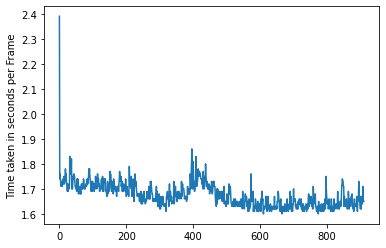

Average Time taken to predict, per Frame: 1.67


In [ ]:
plt.plot(timer)
plt.ylabel("Time taken in seconds per Frame")
plt.show()

print("Average Time taken to predict, per Frame: {:.2f}".format(sum(timer)/len(timer)))